In [2]:
import torch
import torch.nn as nn
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
X = np.load('X.npy')
normalize_c = np.load('normalize_constant.npy')
train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')

In [36]:
train_losses_promax = np.load('train_losses_promax.npy')
val_losses_promax = np.load('val_losses_promax.npy')

In [5]:
normalize_c

array(567.64196324)

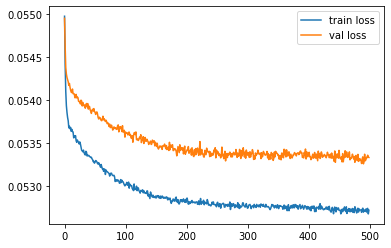

In [7]:
plt.plot(range(train_losses.shape[0]), train_losses)
plt.plot(range(train_losses.shape[0]), val_losses)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

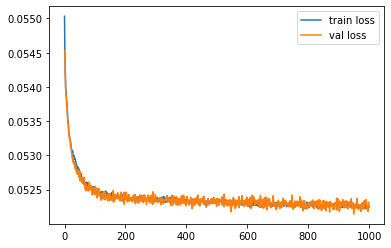

In [37]:
plt.plot(range(train_losses_promax.shape[0]), train_losses_promax)
plt.plot(range(train_losses_promax.shape[0]), val_losses_promax)
plt.legend(['train loss', 'val loss'], loc="upper right")
plt.show()

In [8]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [38]:
class MLP_promax(nn.Module):
    def __init__(self, N, p):
        super(MLP_promax, self).__init__()

        self.fc1 = nn.Linear(N, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss

In [9]:
md = MLP(1100, 1000)
md.load_state_dict(torch.load("My_model.pt"))

<All keys matched successfully>

In [40]:
md_promax = MLP_promax(1100, 1000)
md_promax.load_state_dict(torch.load("My_model_promax.pt"))

<All keys matched successfully>

In [68]:
true_beta = np.zeros((1000,1))
true_beta[:20,0]=2

In [69]:
Y_obs = X @ true_beta + rng.randn(100, 1)
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c

In [58]:
X.shape

(100, 1000)

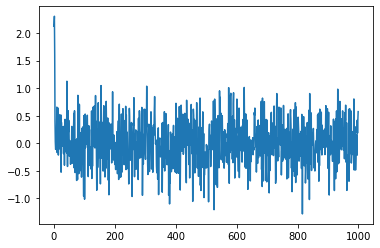

In [61]:
plt.plot((X.T @ Y_obs / 100).reshape(-1))

In [64]:
np.mean(((X.T @ Y_obs / 100).reshape(-1) - true_beta.reshape(-1))**2)

0.1577562275683483

In [67]:
md.eval()
input = np.concatenate((Y_obs, X.T @ Y_obs), axis=0) / normalize_c
input = torch.from_numpy(input.reshape(-1)).type(torch.float)
np.mean((true_beta.reshape(-1) - md(input).detach().numpy().reshape(-1))**2)

0.014344473434330771

In [65]:
(X.T @ Y_obs / 100).reshape(-1)[:6]

array([2.12622556, 2.16600304, 2.30357005, 1.61854618, 0.39269157,
       0.02478868])

In [70]:
md.eval()
input = torch.from_numpy(input.reshape(-1)).type(torch.float)
md(input)

tensor([ 2.5402e-01,  3.1789e-01,  2.6196e-01,  2.1135e-01,  2.5505e-01,
         2.1286e-01,  9.9605e-02,  3.1203e-01,  1.1708e-01,  2.6016e-01,
         4.2103e-01,  2.1091e-01,  2.2853e-01,  2.5048e-01,  2.1392e-01,
         2.4674e-01, -1.0541e-02,  1.7543e-01,  1.3808e-01,  9.4439e-02,
        -2.6357e-02, -1.0207e-01,  7.2417e-03, -4.1193e-03,  6.0100e-02,
        -6.7098e-02,  3.8617e-02,  1.0908e-01, -1.0166e-02, -7.9412e-02,
         7.5979e-03,  3.8513e-02, -4.9613e-02,  2.6059e-01,  8.6502e-02,
        -5.2182e-02,  2.2151e-02,  8.4656e-02, -6.4782e-02,  2.2267e-02,
         1.0502e-01,  1.4940e-01,  2.8848e-02,  1.9660e-01,  6.8792e-02,
        -1.2558e-01, -1.9692e-02, -6.5990e-02, -7.4027e-02,  1.1279e-01,
         1.0209e-01,  5.7528e-02,  6.4545e-02, -4.5198e-02, -9.0034e-02,
        -5.3434e-02, -6.8513e-02, -1.9221e-01,  6.4562e-02, -5.6956e-02,
        -4.3648e-02, -3.7665e-02,  7.3947e-02,  4.7346e-02,  1.9261e-02,
        -1.1740e-03,  8.3406e-02,  1.2577e-02,  1.4

In [51]:
md_promax.eval()
md_promax(input)

tensor([ 1.7048e-01,  2.5596e-01,  1.5697e-01,  4.3154e-01,  2.8514e-01,
         2.0391e-01,  1.4378e-01,  2.1847e-01,  2.6247e-01,  2.1740e-01,
         1.1067e-01,  5.6847e-02,  8.2309e-03,  5.2180e-02,  4.1976e-02,
        -1.6892e-02, -7.0989e-02, -6.7780e-03,  2.5438e-04, -1.1726e-01,
        -5.7655e-02,  1.6462e-02, -3.7654e-02, -9.0756e-03,  1.1513e-02,
         6.9995e-02,  5.3094e-02,  3.0493e-02, -4.9156e-03, -5.2854e-03,
         1.3269e-03,  3.3280e-03, -2.5539e-02,  1.1723e-01,  2.3737e-02,
        -3.6224e-02,  8.2666e-02,  2.9537e-02,  6.2498e-03,  4.8243e-03,
         7.4425e-02,  5.0267e-02,  5.7397e-02,  1.4104e-01,  2.6543e-02,
         1.0218e-02,  1.4754e-03,  7.3392e-03,  3.0939e-02,  2.5787e-02,
         6.2812e-02, -9.6111e-02,  6.9974e-03, -2.5599e-02, -4.5473e-02,
        -2.4246e-02, -2.8824e-03, -7.0226e-02,  7.5663e-02,  3.3587e-02,
        -3.2337e-02, -4.0338e-02,  3.0877e-02,  2.8411e-02,  2.3322e-02,
        -2.4688e-02,  1.0059e-01, -2.7096e-02,  8.9

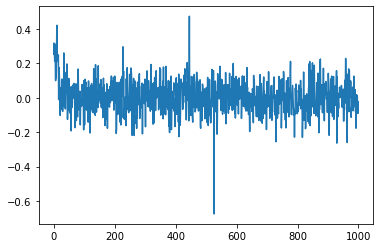

In [71]:
output = md(input).detach().numpy()
plt.plot(output)
plt.show()

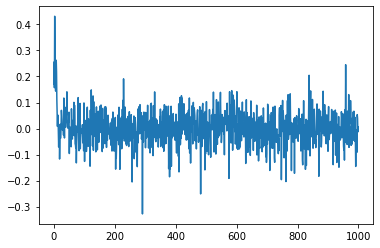

In [53]:
output = md_promax(input).detach().numpy()
plt.plot(output)
plt.show()